# Data Analysis and Classic Machine Learning Techniques
***
# Table of Contents
1.   [Imports](#Imports)
2.   [Loading The Dataset](#Loading-The-Dataset)
3.   [Data Analysis](#Data-Analysis)
4.   [Data Pre-Processing](#Data-Pre-Processing)
4.   [Different Model Comparison](#Different-Model-Comparison)
5.   [Support Vector Machine](#Support-Vector-Machine)


# Imports

The necessary libraries are imported at this stage.

* pandas - Dataframe object is useful for data processing and analyses.
* sklearn - Provides a number of models, metrics and general functionality for machine learning.
* matplotlib - Provides plotting.

In [2]:
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import itertools
import numpy as np
#from google.colab import drive #Only needed on Colab
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
# Pretty display for notebooks
%matplotlib inline

# Loading The Dataset

In this section we load the dataset first from a single file.

Using **sklearn** functions, this dataset is split into the training and testing data, which are then exported as CSV files.

In [7]:
#mount drive
#drive.mount("/content/drive")
#path_to_data = "" #"drive/MyDrive/Kaggle/"

train = pd.read_csv("Our Datasets/train.csv", encoding="utf-8")
test = pd.read_csv("Our Datasets/test.csv", encoding="utf-8")

#Check it loaded ok
#display(train.head(n=1))
#display(test.head(n=1))

In [4]:
#y = all_data.Label
#X = all_data.drop('Label', axis=1)
train_pct_index = int(0.8 * len(all_data))
all_data = shuffle(all_data)

train, test = all_data[:train_pct_index], all_data[train_pct_index:]


print("\nTrain:\n")
print(train.head())
print(train.shape)

print("\nTest:\n")
print(test.head())
print(test.shape)


train:

          Label  fBodyAcc-X-energy()  fBodyAcc-X-entropy()  fBodyAcc-X-iqr()  \
1732    SITTING           377.682873              3.623968          0.612970   
1705    SITTING             8.877243              4.388740          0.285346   
861     WALKING        224846.847700              4.085404         21.919973   
337     DRIVING          1889.130323              4.271651          2.919831   
1433  STAIRS UP         93448.774420              4.250699         27.400539   

      fBodyAcc-X-kurtosis  fBodyAcc-X-mad()  fBodyAcc-X-max()  \
1732             6.158818          0.103988          6.932625   
1705             0.109292          0.092098          0.743932   
861              4.035486          7.265689        161.010398   
337              3.149879          1.159611         13.659620   
1433             0.866049          8.497246         78.587437   

      fBodyAcc-X-maxInds  fBodyAcc-X-mean()  fBodyAcc-X-min()  ...  \
1732            2.343750           0.789874      

# Data Analysis

In this section analysis over the data is done to determine the processing steps necessary for the [next section](#Data-Pre-Processing).

## Check for Common Elements

The training and test data are merged using inner join to see if there is any overlapping data. The output is an empty data frame - containing only the list of different features - meaning that there are no intersections between the two.

In [8]:
merged = pd.merge(train, test, how='inner')
print(merged)

Empty DataFrame
Columns: [Label, fBodyAcc-X-energy(), fBodyAcc-X-entropy(), fBodyAcc-X-iqr(), fBodyAcc-X-kurtosis, fBodyAcc-X-mad(), fBodyAcc-X-max(), fBodyAcc-X-maxInds, fBodyAcc-X-mean(), fBodyAcc-X-min(), fBodyAcc-X-skewness, fBodyAcc-X-std(), fBodyAcc-Y-energy(), fBodyAcc-Y-entropy(), fBodyAcc-Y-iqr(), fBodyAcc-Y-kurtosis, fBodyAcc-Y-mad(), fBodyAcc-Y-max(), fBodyAcc-Y-maxInds, fBodyAcc-Y-mean(), fBodyAcc-Y-min(), fBodyAcc-Y-skewness, fBodyAcc-Y-std(), fBodyAcc-Z-energy(), fBodyAcc-Z-entropy(), fBodyAcc-Z-iqr(), fBodyAcc-Z-kurtosis, fBodyAcc-Z-mad(), fBodyAcc-Z-max(), fBodyAcc-Z-maxInds, fBodyAcc-Z-mean(), fBodyAcc-Z-min(), fBodyAcc-Z-skewness, fBodyAcc-Z-std(), fBodyAcc-sma(), fBodyAccJerk-X-energy(), fBodyAccJerk-X-entropy(), fBodyAccJerk-X-iqr(), fBodyAccJerk-X-kurtosis, fBodyAccJerk-X-mad(), fBodyAccJerk-X-max(), fBodyAccJerk-X-maxInds, fBodyAccJerk-X-mean(), fBodyAccJerk-X-min(), fBodyAccJerk-X-skewness, fBodyAccJerk-X-std(), fBodyAccJerk-Y-energy(), fBodyAccJerk-Y-entropy(), 

## Shuffle the data

In [21]:
train = shuffle(train)
test = shuffle(test)

## Check for null values in rows

In [9]:
print("Any missing sample in training set:", train.isnull().values.any())
print("Any missing sample in test set:", test.isnull().values.any(), "\n")

Any missing sample in training set: False
Any missing sample in test set: False 



## Label Distribution

### Label Distribution in a Pie Chart

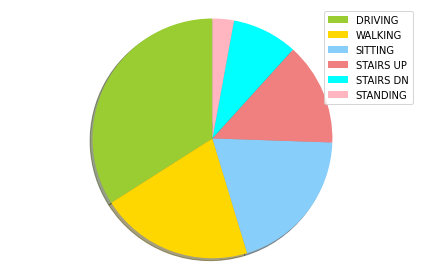

In [10]:
# Visualizing Activity Distribution
temp = train["Label"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan','lightpink']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

### Label Distribution in a Column Format

In [11]:
train_outcome = pd.crosstab(index=train["Label"],
                              columns="count")

train_outcome

col_0,count
Label,
DRIVING,578
SITTING,336
STAIRS DN,150
STAIRS UP,235
STANDING,49
WALKING,351


# Data Pre-Processing

The dataset only requires a small number of pre-processing mainly, splitting the sets into X and y variables, categorical
variable encoding (for the label), and scaling.

The *activity* and *subject* columns are removed from the training and test data. **Y_train_label** and **Y_test_label** are the classifications of the activity of each row in the respective dataframes.

In [12]:
X_train = pd.DataFrame(train.drop(['Label'],axis=1))
Y_train_label = train.Label.values.astype(object)
X_test = pd.DataFrame(test.drop(['Label'],axis=1))
Y_test_label = test.Label.values.astype(object)

print("Dimension of Train set",X_train.shape)
print("Dimension of Test set",X_test.shape,"\n")

# Transforming non numerical labels into numerical labels
encoder = preprocessing.LabelEncoder()

# encoding train labels
encoder.fit(Y_train_label)
Y_train = encoder.transform(Y_train_label)

# encoding test labels
encoder.fit(Y_test_label)
Y_test = encoder.transform(Y_test_label)

#Total Number of Continuous features in the training set
num_cols = X_train._get_numeric_data().columns
print("Number of Continuous Features:",num_cols.size)

#names_of_predictors = list(X_train.columns.values) #Names of each feature

# Scaling the Train and Test feature set
# Because - values and classification
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #fit_transform is performed on training data
X_test_scaled = scaler.transform(X_test) #transform is performed on test data

Dimension of Train set (1699, 325)
Dimension of Test set (425, 325) 

Number of Continuous Features: 325


# Different Model Comparison

In this step we compare 3 classic ml models.

In [13]:
clf_A = GaussianNB()
clf_B = AdaBoostClassifier(random_state=0)
clf_C = SVC(random_state=0)

learners = {}
learners["Gaussian Naive Bayes"] = clf_A
learners["AdaBoost"] = clf_B
learners["Support Vector Machine"] = clf_C

def train_predict(learners, X_train, y_train, X_test, y_test):
    for learner in learners:
        print("Learner:", learner,"\n------")
        print("Training Data")
        start = time()
        learners[learner].fit(X_train, y_train)
        end = time()
        print("Time taken:", end-start, "seconds")

        print("Testing Data")
        start = time()
        predictions_test = learners[learner].predict(X_test)
        end = time()
        print("Time taken:", end-start, "seconds")


        print("\nAccuracy Score")
        print(accuracy_score(y_test,predictions_test))

        print("\nBeta Score")
        print(fbeta_score(y_test,predictions_test,beta=0.5,average='weighted'))

        print("\nPrecision Score")
        print(precision_score(y_test, predictions_test, average='weighted'))

        print("\nRecall Score")
        print(recall_score(y_test, predictions_test, average='weighted'),'\n')

train_predict(learners, X_train_scaled, Y_train, X_test_scaled, Y_test)

Learner: Gaussian Naive Bayes 
------
Training Data
Time taken: 0.007001161575317383 seconds
Testing Data
Time taken: 0.005999326705932617 seconds

Accuracy Score
0.8941176470588236

Beta Score
0.894044859161165

Precision Score
0.8945770303881412

Recall Score
0.8941176470588236 

Learner: AdaBoost 
------
Training Data
Time taken: 2.378997325897217 seconds
Testing Data
Time taken: 0.015001058578491211 seconds

Accuracy Score
0.6635294117647059

Beta Score
0.5824664497926864

Precision Score
0.5819000825565273

Recall Score
0.6635294117647059 

Learner: Support Vector Machine 
------
Training Data
Time taken: 0.07499504089355469 seconds
Testing Data
Time taken: 0.05000042915344238 seconds

Accuracy Score
0.9811764705882353

Beta Score
0.9817395620318203

Precision Score
0.982263877212788

Recall Score
0.9811764705882353 

C:\Users\Jake Sant\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined

As can be seen from the above metrics, SVM is quite clearly the most accurate classifier of the three, and it is for that reason that we will use it as one of the main classifiers for the group practical task

# Support Vector Classifier

There are a number of different parameters we can apply to SVC in order to obtain the best results possible. These different parameters were passed through a Grid Search model, which applies all of them to train various SVCs.

In [18]:
clf = SVC(random_state=0)

parameters =    {
                "kernel": ['poly', 'rbf', 'sigmoid'],
                "C": [50, 10, 1.0, 0.1, 0.01],
                "gamma": ['scale']
                }

scorer = make_scorer(fbeta_score, beta=0.5,average='weighted')
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train_scaled,Y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
clf.fit(X_train_scaled, Y_train)
# Make predictions using the unoptimized and model
predictions = clf.predict(X_test)
best_predictions = best_clf.predict(X_test_scaled)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on the testing data: {:.4f}".format(accuracy_score(Y_test, predictions)))
print("F-score on the testing data: {:.4f}".format(fbeta_score(Y_test, predictions, beta = 0.5,average='weighted')))
print("Precision score on the testing data: {:.4f}".format(precision_score(Y_test, predictions, average='weighted')))
print("Recall score on the testing data: {:.4f}".format(recall_score(Y_test, predictions, average='weighted')))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(Y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(Y_test, best_predictions, beta = 0.5,average='weighted')))
print("Final precision score on the testing data: {:.4f}".format(precision_score(Y_test, best_predictions, average='weighted')))
print("Final recall score on the testing data: {:.4f}".format(recall_score(Y_test, best_predictions, average='weighted')))

Unoptimized model
------
Accuracy score on the testing data: 0.1718
F-score on the testing data: 0.0354
Precision score on the testing data: 0.0295
Recall score on the testing data: 0.1718

Optimized Model
------
Final accuracy score on the testing data: 0.9788
Final F-score on the testing data: 0.9794
Final precision score on the testing data: 0.9799
Final recall score on the testing data: 0.9788
C:\Users\Jake Sant\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


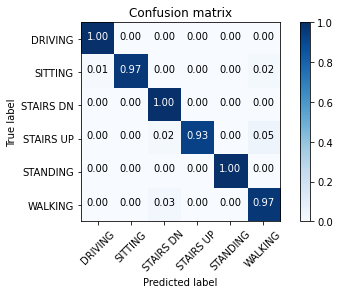

In [19]:
#Confusion Matrix maps out the predicted label given to the data with the actual label
#Helps us check the rate of true/false positives and true/false negatives
#parameters are the true labels, and the predicted labels

# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(Y_test, best_predictions)
np.set_printoptions(precision=2)

classes =    {
                        "DRIVING":0,
                        "SITTING":1,
                        "STAIRS DN":2,
                        "STAIRS UP":3,
                        "STANDING":4,
                        "WALKING":5
                    }

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,title='Confusion matrix')


In [20]:
print("The best parameters were:", grid_fit.best_params_)


The best parameters were: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
